In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import pandas as pd

In [75]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [77]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [79]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [80]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [81]:
# Set up the inspector
inspector = inspect(engine)

In [82]:
# Find the column headers for each table
columnsm = inspector.get_columns('measurement')
for column in columnsm:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [83]:
columnss = inspector.get_columns('station')
for column in columnss:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [84]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

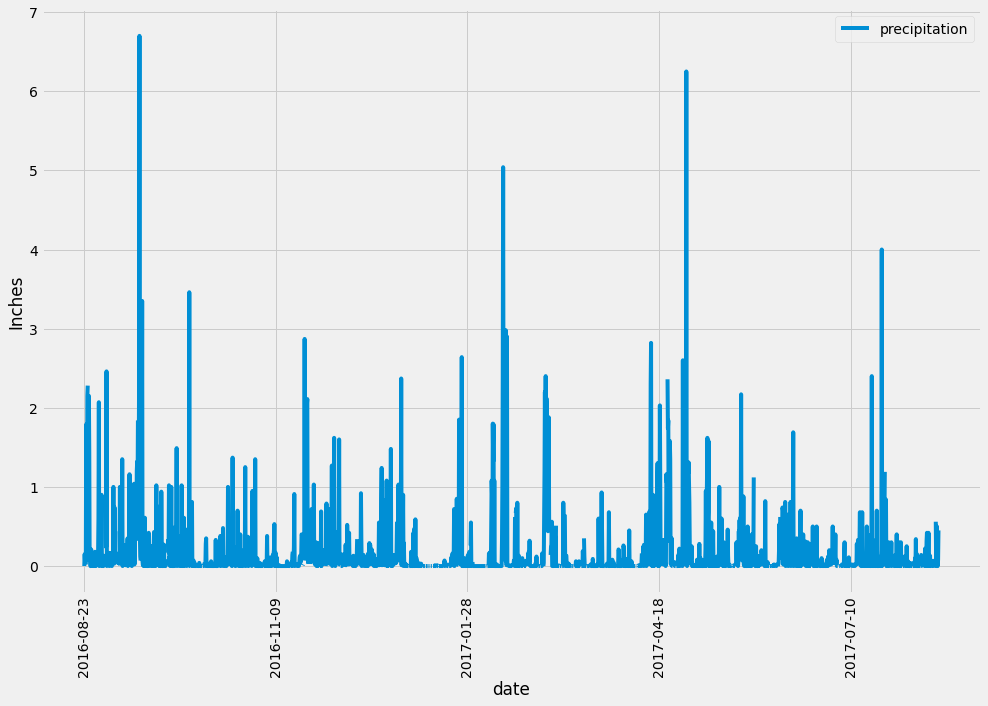

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
response = session.query(Measure.date, Measure.prcp).order_by(Measure.date).filter(Measure.date >= '2016-08-23').all()
response

listy = []
for row in response:
    listy.append(row)

measure_df = pd.DataFrame(listy, columns = ['date', 'precipitation'])
measure_df

# Use Pandas Plotting with Matplotlib to plot the data
measure_df.plot(x = 'date', y = 'precipitation', rot = 90, figsize = (15,10))
plt.ylabel('Inches')

In [86]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [87]:
# Design a query to show how many stations are available in this dataset?
count = session.query(func.count(Measure.station)).group_by(Measure.station).count()
count

9

In [88]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity = session.query(Measure.station, func.count(Measure.station)).group_by(Measure.station).\
    order_by(func.count(Measure.station).desc()).all()
activity
most_active = session.query(Measure.station).group_by(Measure.station).\
    order_by(func.count(Measure.station).desc()).first()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_temp = session.query(func.min(Measure.tobs)).filter(Measure.station == most_active[0]).all()
print(f'The lowest temp recorded is {low_temp[0][0]}')
max_temp = session.query(func.max(Measure.tobs)).filter(Measure.station == most_active[0]).all()
print(f'The highest temp recorded is {max_temp[0][0]}')
avg_temp = session.query(func.avg(Measure.tobs)).filter(Measure.station == most_active[0]).all()
print(f'The average temp is {avg_temp[0][0]}')

The lowest temp recorded is 54.0
The highest temp recorded is 85.0
The average temp is 71.66378066378067


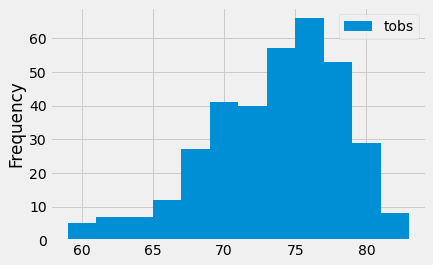

In [90]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
statresponse = session.query(Measure.date, Measure.tobs).order_by(Measure.date).filter(Measure.date >= '2016-08-23').\
    filter(Measure.station == most_active[0]).all()
listoo = []
for row in statresponse:
    listoo.append(row)
stat_df = pd.DataFrame(listoo, columns = ['date', 'tobs'])
stat_df.plot.hist(by= 'tobs', bins = 12)

## Bonus Challenge Assignment

### Temp analysis 1

In [103]:
from scipy import stats
june = "06"
june_avg = session.query(Measure.tobs).filter(func.strftime("%m", Measure.date) == june).all()
december = "12"
december_avg = session.query(Measure.tobs).filter(func.strftime("%m", Measure.date) == december).all()
dec = list(np.ravel(december_avg))
jun = list(np.ravel(june_avg))
# print(june_avg)
# print(december_avg)
stats.ttest_ind(jun, dec)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### Temp analysis 2

In [92]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2011-02-28', '2011-03-05')
trip_temp

[(61.0, 69.75510204081633, 75.0)]

Text(0.5, 1.0, 'Trip Avg Temp')

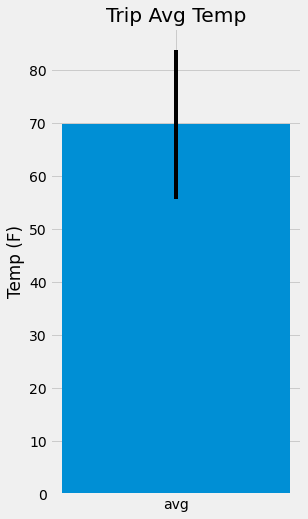

In [109]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ticks = ['avg']
ptp = trip_temp[0][2] - trip_temp[0][0]
plt.figure(figsize = (4, 8))
plt.bar(ticks, trip_temp[0][1], yerr = ptp)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')

In [95]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [
    func.sum(Measure.prcp),
    Measure.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation
]
rain = session.query(*sel).group_by(Measure.station).filter(Measure.station == Station.station).\
    filter(Measure.date >= '2011-02-28').filter(Measure.date <= '2011-03-05').\
    order_by(func.sum(Measure.prcp).desc()).all()
rain

[(2.33,
  'USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 (2.23,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (2.19,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (1.96,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (1.45,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (1.44, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (1.38, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.63,
  'USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

### Daily Averages

In [96]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [97]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
days = ["02-28", "02-29", "03-01", "03-02", "03-03", "03-04", "03-05"]
normals = []
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in days:
    result = daily_normals(day)
    normals.append(result[0])
normals



[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [98]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
days_df = pd.DataFrame(normals, columns = ['min', 'avg', 'max'])
days_df.insert(0, 'date', days)
days_df.set_index('date')

,min,avg,max
date,,,
02-28,65.0,70.655172,80.0
02-29,67.0,71.733333,79.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


([<matplotlib.axis.XTick at 0x1456ff15a90>,
 [Text(0, 0, '02-28'),
  Text(0, 0, '02-29'),
  Text(0, 0, '03-01'),
  Text(0, 0, '03-02'),
  Text(0, 0, '03-03'),
  Text(0, 0, '03-04'),
  Text(0, 0, '03-05')])

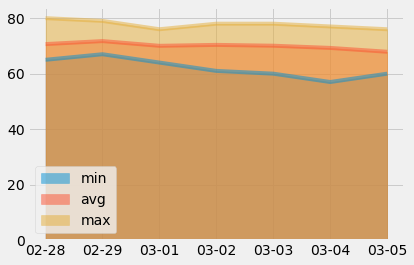

In [99]:
# Plot the daily normals as an area plot with `stacked=False`
days_df.plot.area(stacked = False)
plt.xticks(ticks = np.arange(len(days)), labels = days)